In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# create Python 3.11 env and register as a Jupyter kernel
# !conda create -y -n logit_graph_py311 python=3.11
# !conda run -n logit_graph_py311 python -m pip install -U pip setuptools wheel
# !conda run -n logit_graph_py311 python -m pip install -e "/Users/maruanottoni/home/master/research/logit-graph"
# !conda run -n logit_graph_py311 python -m ipykernel install --user --name logit_graph_py311 --display-name "Python (logit_graph_py311)"
#from logit_graph import LogitGraphFitter

here the objective is to fit the logit graph model to multiple different graph domains and then visualize the original vs fitted graphs

In [3]:
import sys
import os
sys.path.append('../..')

#Graph imports
import src.logit_graph.graph as graph
import src.logit_graph.logit_estimator as estimator
import src.logit_graph.utils as utils
import src.logit_graph.model_selection as model_selection
import src.logit_graph.gic as gic
import src.logit_graph.param_estimator as pe
import src.logit_graph.graph as graph
import src.logit_graph.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [4]:
FOLDER_OUTPUT = f'runs/fitted_graphs_comparison_twitch'
out_files = os.listdir(FOLDER_OUTPUT)
out_files = sorted(out_files, key=lambda x: os.path.getctime(os.path.join(FOLDER_OUTPUT, x)), reverse=True)

out_files

['comparators_DE_graph_sample.pkl',
 'comparators_ENGB_graph.pkl',
 'comparators_FR_graph.pkl',
 'comparators_ENGB_graph_sample.pkl',
 'comparators_FR_graph_sample.pkl',
 'comparators_ES_graph_sample.pkl',
 'comparators_ES_graph.pkl',
 'comparators_RU_graph.pkl',
 'comparators_PTBR_graph.pkl']

In [ ]:
import sys, importlib, pickle, gc
sys.modules['src.simulation'] = importlib.import_module('src.logit_graph.simulation')  # or 'logit_graph.simulation'

comparators_all = []
for file in out_files:
    print(file)
    with open(f'{FOLDER_OUTPUT}/{file}', 'rb') as f:
        comparator = pickle.load(f)
    # Pick the latest element on the list of comparator
    comparator = comparator[-1]
    df = comparator.summary_df
    print(df)
    comparators_all.append(df)
    del comparator
    gc.collect()


comparators_DE_graph_sample.pkl


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1055c9280>>
Traceback (most recent call last):
  File "/Users/maruanottoni/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [9]:
dfs=comparators_all

In [10]:
# remove dupplicate rows across df and dfs
#dfs = [df.drop_duplicates() for df in dfs]

len(dfs)
dfs[0]


graph_filename     model  gic_value               param  fit_success  \
0  DE_graph.edges  Original        NaN                 N/A         True   
1  DE_graph.edges        LG   0.184310  d=1, sigma=-7.0523         True   
2  DE_graph.edges        BA   0.972094                 1.0         True   
3  DE_graph.edges        WS   1.349088               20.01         True   
4  DE_graph.edges        ER   1.490809                0.01         True   
5  DE_graph.edges       GRG   6.021176                 1.0         True   

   nodes     edges   density  avg_clustering  avg_path_length  diameter  \
0   9498    153138  0.003395        0.200886         2.721571         7   
1   9498     77067  0.001709        0.001675         3.601888         5   
2   9498      9497  0.000211        0.000000         9.198725        26   
3   9498    151968  0.003369        0.003266         2.929834         4   
4   9498    451892  0.010019        0.010030         2.371600         3   
5   9498  43980505  0.975150        0.978203         1.024850         2   

   assortativity  num_components  largest_component_size  
0      -0.115173               1                    9498  
1       0.002250               1                    9498  
2      -0.069827               1                    9498  
3      -0.013161               1                    9498  
4      -0.001069               1                    9498  
5      -0.034142               1                    9498

In [11]:
# Create a DataFrame with GIC values for each model and graph, including node and edge count
gic_df = pd.DataFrame()

for df in dfs:
    graph_name = df['graph_filename'].iloc[0]
    # Get GIC values for each model (excluding Original which has NaN)
    model_gics = df[df['model'] != 'Original'].set_index('model')['gic_value']
    # Add node and edge count from the Original model
    original_row = df[df['model'] == 'Original'].iloc[0]
    model_gics['nodes'] = original_row['nodes']
    model_gics['edges'] = original_row['edges']
    gic_df[graph_name] = model_gics

# Transpose so graphs are rows and models are columns
gic_df = gic_df.T
gic_df

model                   LG        BA        WS        ER        GRG   nodes  \
DE_graph.edges    0.184310  0.972094  1.349088  1.490809   6.021176  9498.0   
ENGB_graph.edges  0.185198  0.795073  0.796308  5.164677  11.241122  7126.0   
FR_graph.edges    0.215726  0.935441  1.418457  0.403070   5.297629  6549.0   
ES_graph.edges    0.246086  0.306256  1.226700  1.075509   6.910762  4648.0   
RU_graph.edges    0.189576  0.410948  1.058631  2.172463   8.557508  4385.0   
PTBR_graph.edges  0.328175  0.495998  1.385952  0.629600   4.865420  1912.0   

model                edges  
DE_graph.edges    153138.0  
ENGB_graph.edges   35324.0  
FR_graph.edges    112666.0  
ES_graph.edges     59382.0  
RU_graph.edges     37304.0  
PTBR_graph.edges   31299.0

In [12]:
# Create a dictionary to store rankings for each graph
rankings = {}

# Go through each df in dfs
for df in dfs:
    graph_name = df['graph_filename'].iloc[0]  # Get graph filename
    
    # Sort models by GIC value (excluding 'Original' which has NaN GIC)
    model_ranks = df[df['model'] != 'Original'].sort_values('gic_value')['model'].tolist()
    
    # Create rankings dictionary for this graph (1 is best since lowest GIC is best)
    rankings[graph_name] = {
        model: rank+1 for rank, model in enumerate(model_ranks)
    }
    
    # Add nodes and edges from Original model
    original_row = df[df['model'] == 'Original'].iloc[0]
    rankings[graph_name]['nodes'] = original_row['nodes']
    rankings[graph_name]['edges'] = original_row['edges']

# Get unique models (excluding 'Original')
models = sorted(list(set([model for df in dfs for model in df['model'].unique() if model != 'Original'])))

# Create DataFrame with rankings
ranking_df = pd.DataFrame(rankings).T

# Ensure all models are present as columns
for model in models:
    if model not in ranking_df.columns:
        ranking_df[model] = np.nan

# Keep only the model columns in a consistent order, plus nodes and edges
ranking_df = ranking_df[models + ['nodes', 'edges']]

print("Rankings by GIC value (lower is better):")
display(ranking_df)


Rankings by GIC value (lower is better):


BA  ER  GRG  LG  WS  nodes   edges
DE_graph.edges     2   4    5   1   3   9498  153138
ENGB_graph.edges   2   4    5   1   3   7126   35324
FR_graph.edges     3   2    5   1   4   6549  112666
ES_graph.edges     2   3    5   1   4   4648   59382
RU_graph.edges     2   4    5   1   3   4385   37304
PTBR_graph.edges   2   3    5   1   4   1912   31299

In [13]:
ranking_df.mean(axis=0)

BA           2.166667
ER           3.333333
GRG          5.000000
LG           1.000000
WS           3.500000
nodes     5686.333333
edges    71518.833333
dtype: float64

In [14]:
ranking_df['nodes'].describe()

count       6.000000
mean     5686.333333
std      2621.558061
min      1912.000000
25%      4450.750000
50%      5598.500000
75%      6981.750000
max      9498.000000
Name: nodes, dtype: float64

In [15]:
len(ranking_df)

6

# Gen single plot

In [5]:
FOLDER_OUTPUT = f'runs/fitted_graphs_comparison_twitch'
out_files = os.listdir(FOLDER_OUTPUT)
out_files = sorted(out_files, key=lambda x: os.path.getctime(os.path.join(FOLDER_OUTPUT, x)), reverse=True)

out_files

['comparators_DE_graph_sample.pkl',
 'comparators_ENGB_graph.pkl',
 'comparators_FR_graph.pkl',
 'comparators_ENGB_graph_sample.pkl',
 'comparators_FR_graph_sample.pkl',
 'comparators_ES_graph_sample.pkl',
 'comparators_ES_graph.pkl',
 'comparators_RU_graph.pkl',
 'comparators_PTBR_graph.pkl']

In [6]:
import sys, importlib, pickle, gc
sys.modules['src.simulation'] = importlib.import_module('src.logit_graph.simulation')  # or 'logit_graph.simulation'

In [7]:
file = out_files[-1]
with open(f'{FOLDER_OUTPUT}/{file}', 'rb') as f:
    print(f'{FOLDER_OUTPUT}/{file}')
    comparators = pickle.load(f)
    print(len(comparators))

runs/fitted_graphs_comparison_twitch/comparators_PTBR_graph.pkl
1


In [8]:
comparator = comparators[0]
print(comparator.summary_df.nodes.unique())
#comparator.__dict__

[1912]


In [9]:
graphs_names = list(comparator.fitted_graphs_data.keys())
graphs_names

['Original', 'LG', 'BA', 'ER', 'WS', 'GRG']

In [10]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch

def circos_plot(
    G,
    order="community",
    color="community",
    n_subsample_nodes=2500,
    max_edges=40000,
    node_size=5,
    edge_alpha=0.06,
    edge_lw=0.25,
    base_edge_rad=0.12,
    figsize=(12, 12),
    seed=42,
    show_labels=False,
    ax=None                       # NEW: draw on this axes if provided
):
    rng = random.Random(seed)

    H = G
    if n_subsample_nodes and H.number_of_nodes() > n_subsample_nodes:
        nodes = rng.sample(list(H.nodes()), n_subsample_nodes)
        H = H.subgraph(nodes).copy()

    if H.number_of_nodes() == 0:
        raise ValueError("Graph has no nodes after sampling.")

    try:
        if not nx.is_connected(H):
            comp = max(nx.connected_components(H), key=len)
            H = H.subgraph(comp).copy()
    except nx.NetworkXError:
        pass

    if isinstance(order, (list, tuple)):
        nodes_ordered = [n for n in order if n in H]
    elif order == "degree":
        nodes_ordered = sorted(H, key=lambda n: H.degree(n), reverse=True)
    elif order == "community":
        try:
            coms = list(nx.algorithms.community.greedy_modularity_communities(H))
            nodes_ordered = [n for c in sorted(coms, key=len, reverse=True)
                               for n in sorted(c, key=lambda x: H.degree(x), reverse=True)]
        except Exception:
            nodes_ordered = sorted(H, key=lambda n: H.degree(n), reverse=True)
    elif order == "random":
        nodes_ordered = list(H.nodes())
        rng.shuffle(nodes_ordered)
    else:
        nodes_ordered = list(H.nodes())

    n = len(nodes_ordered)
    angles = np.linspace(0, 2 * math.pi, n, endpoint=False)
    pos = {node: (math.cos(t), math.sin(t)) for node, t in zip(nodes_ordered, angles)}
    node_index = {node: i for i, node in enumerate(nodes_ordered)}

    if color == "degree":
        vals = np.array([H.degree(n) for n in nodes_ordered], dtype=float)
        vals = (vals - vals.min()) / (vals.max() - vals.min() + 1e-12)
        node_colors, node_cmap = vals, "viridis"
    elif color == "community":
        try:
            coms = list(nx.algorithms.community.greedy_modularity_communities(H))
            lut = {n: i for i, c in enumerate(coms) for n in c}
            node_colors = [lut.get(n, 0) for n in nodes_ordered]
            node_cmap = "tab20"
        except Exception:
            node_colors, node_cmap = "#1f77b4", None
    elif isinstance(color, (list, tuple, np.ndarray)):
        node_colors, node_cmap = color, None
    else:
        node_colors, node_cmap = color, None

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        created_fig = True
    else:
        fig = ax.figure

    ax.set_aspect("equal")
    ax.axis("off")

    ring = plt.Circle((0, 0), 1.03, color="#9558b2", fill=False, lw=0.7, alpha=0.6)
    ax.add_artist(ring)

    nx.draw_networkx_nodes(
        H, pos, nodelist=nodes_ordered, node_size=node_size,
        node_color=node_colors, cmap=node_cmap, linewidths=0.0, ax=ax
    )

    edges = list(H.edges())
    if max_edges is not None and len(edges) > max_edges:
        edges = rng.sample(edges, max_edges)

    for u, v in edges:
        i, j = node_index[u], node_index[v]
        d = abs(i - j) / n
        d = min(d, 1 - d)
        rad = (1.0 - 2.0 * d) * base_edge_rad
        p0, p1 = pos[u], pos[v]
        patch = FancyArrowPatch(
            p0, p1, arrowstyle="-",
            connectionstyle=f"arc3,rad={rad}",
            color="k", alpha=edge_alpha, lw=edge_lw
        )
        ax.add_patch(patch)

    if show_labels and n <= 120:
        nx.draw_networkx_labels(H, pos, font_size=6, ax=ax)

    if created_fig:
        plt.tight_layout()
        plt.show()
    return fig, ax

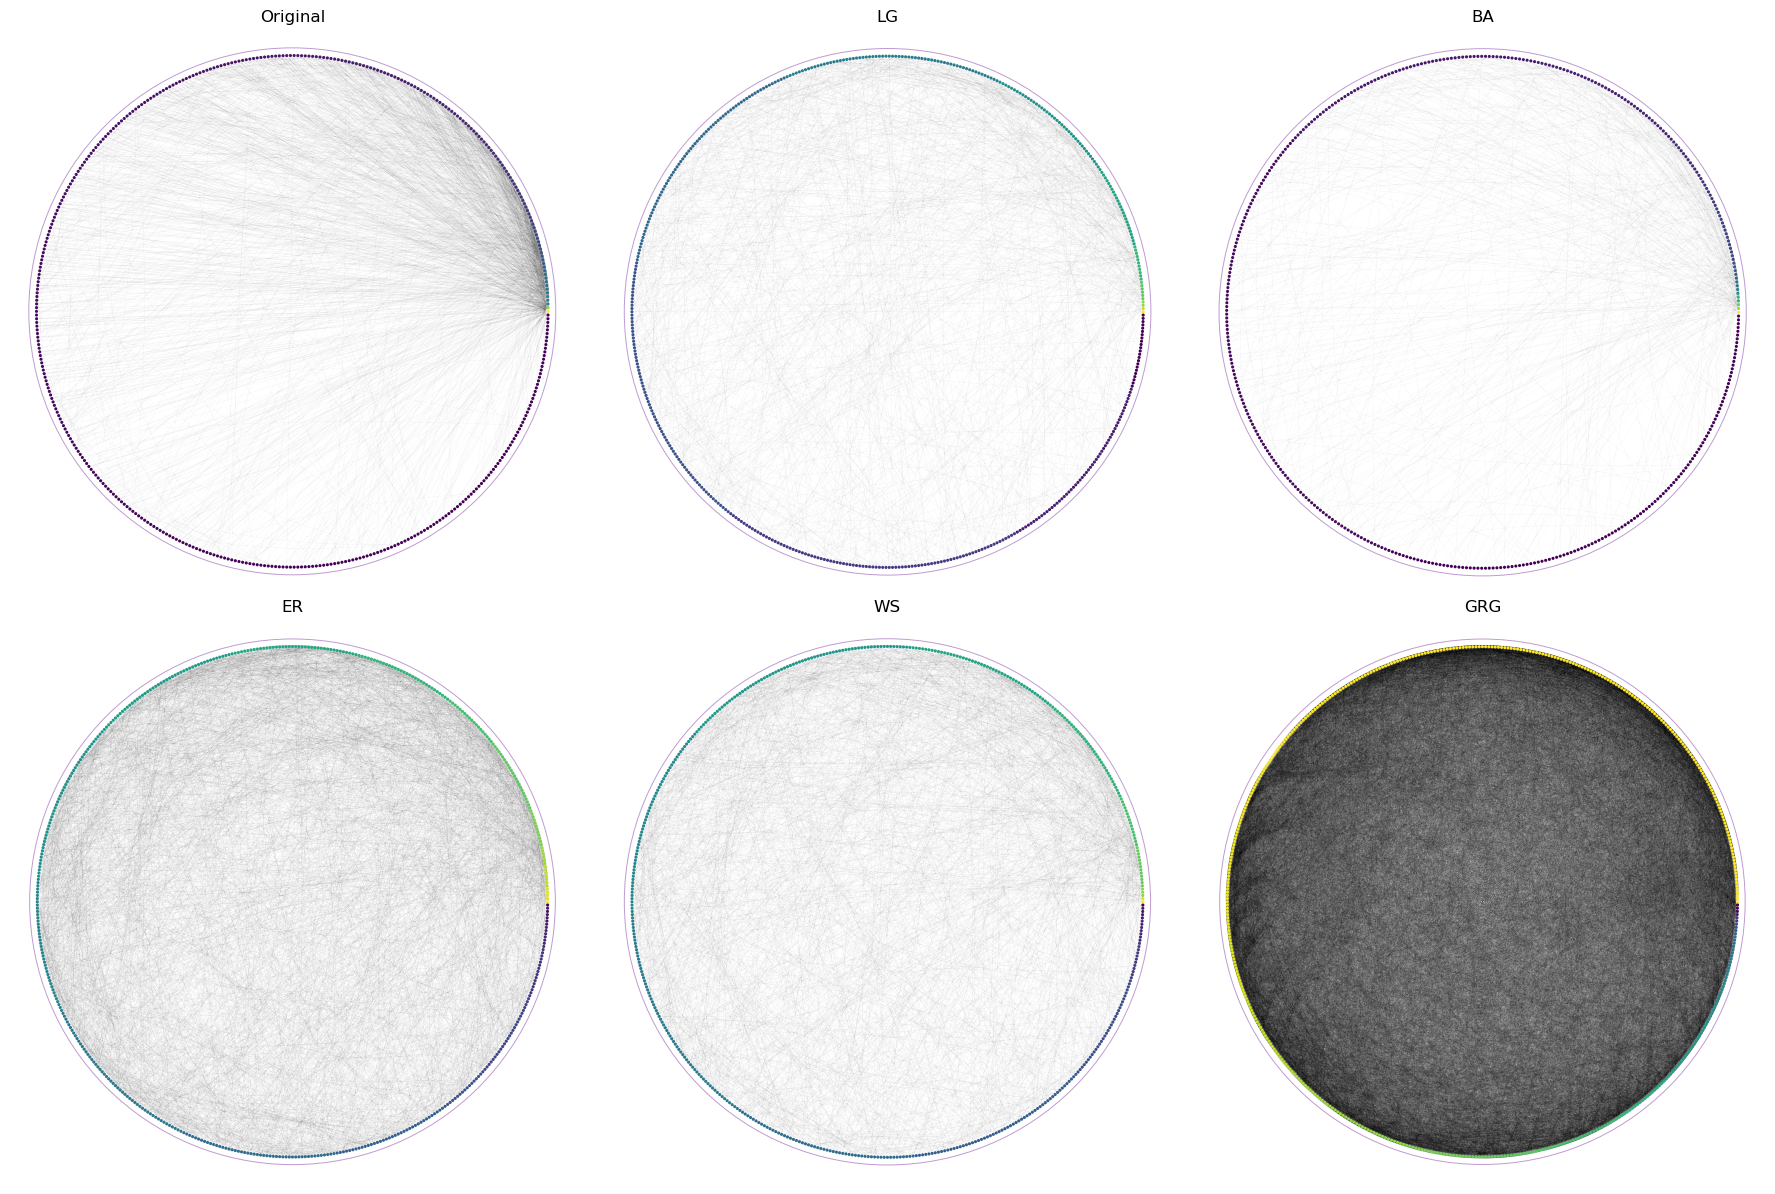

In [11]:
n_graphs = len(graphs_names)
n_cols = 3
n_rows = (n_graphs + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
axes = axes.flatten()

# Plot each graph
for i, graph_name in enumerate(graphs_names):
    G = comparator.fitted_graphs_data[graph_name]["graph"]
    axes[i].set_title(graph_name)
    circos_plot(
        G,
        order="degree", 
        color="degree",
        n_subsample_nodes=500,
        max_edges=30000,
        node_size=5,
        edge_alpha=0.05,
        edge_lw=0.25,
        base_edge_rad=0.12,
        ax=axes[i]
    )

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Gen all Plots

In [112]:
# Sort comparators_all by number of nodes in real graph
comparators_all = sorted(comparators_all, 
                        key=lambda x: x.fitted_graphs_data['Original']['graph'].number_of_nodes())


twitch_0_PTBR_graph.edges


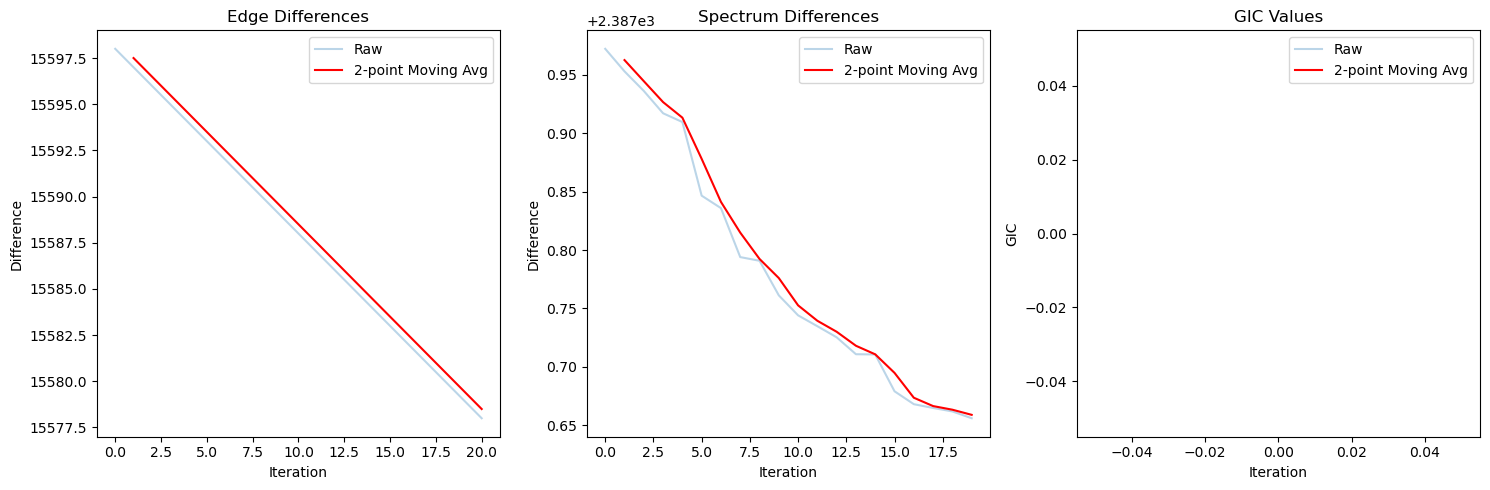

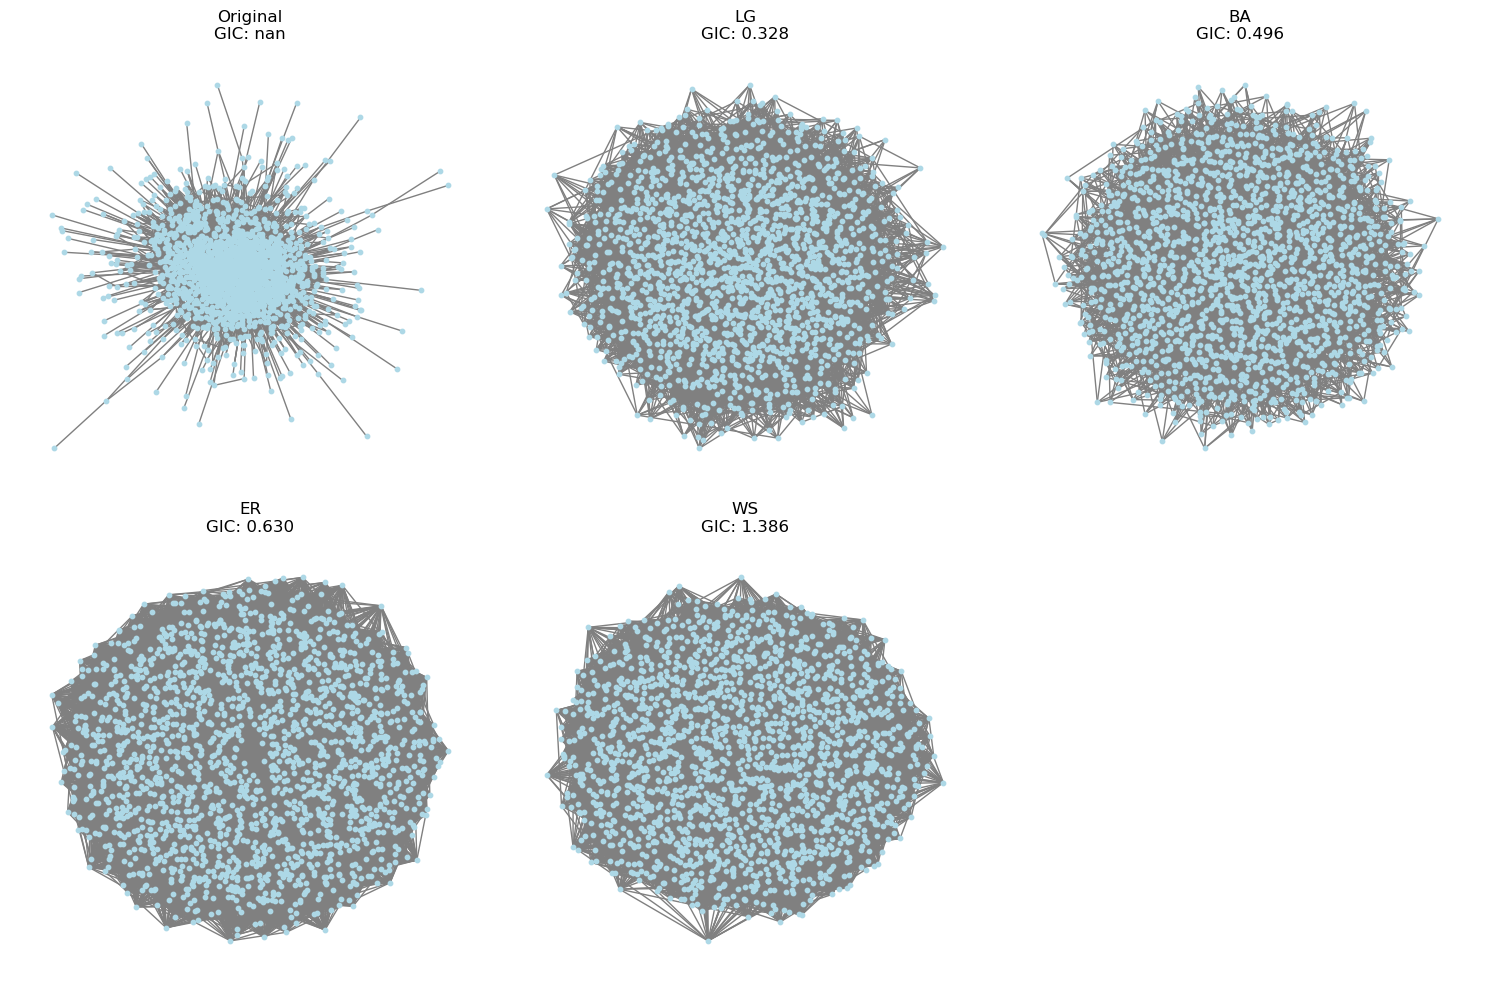

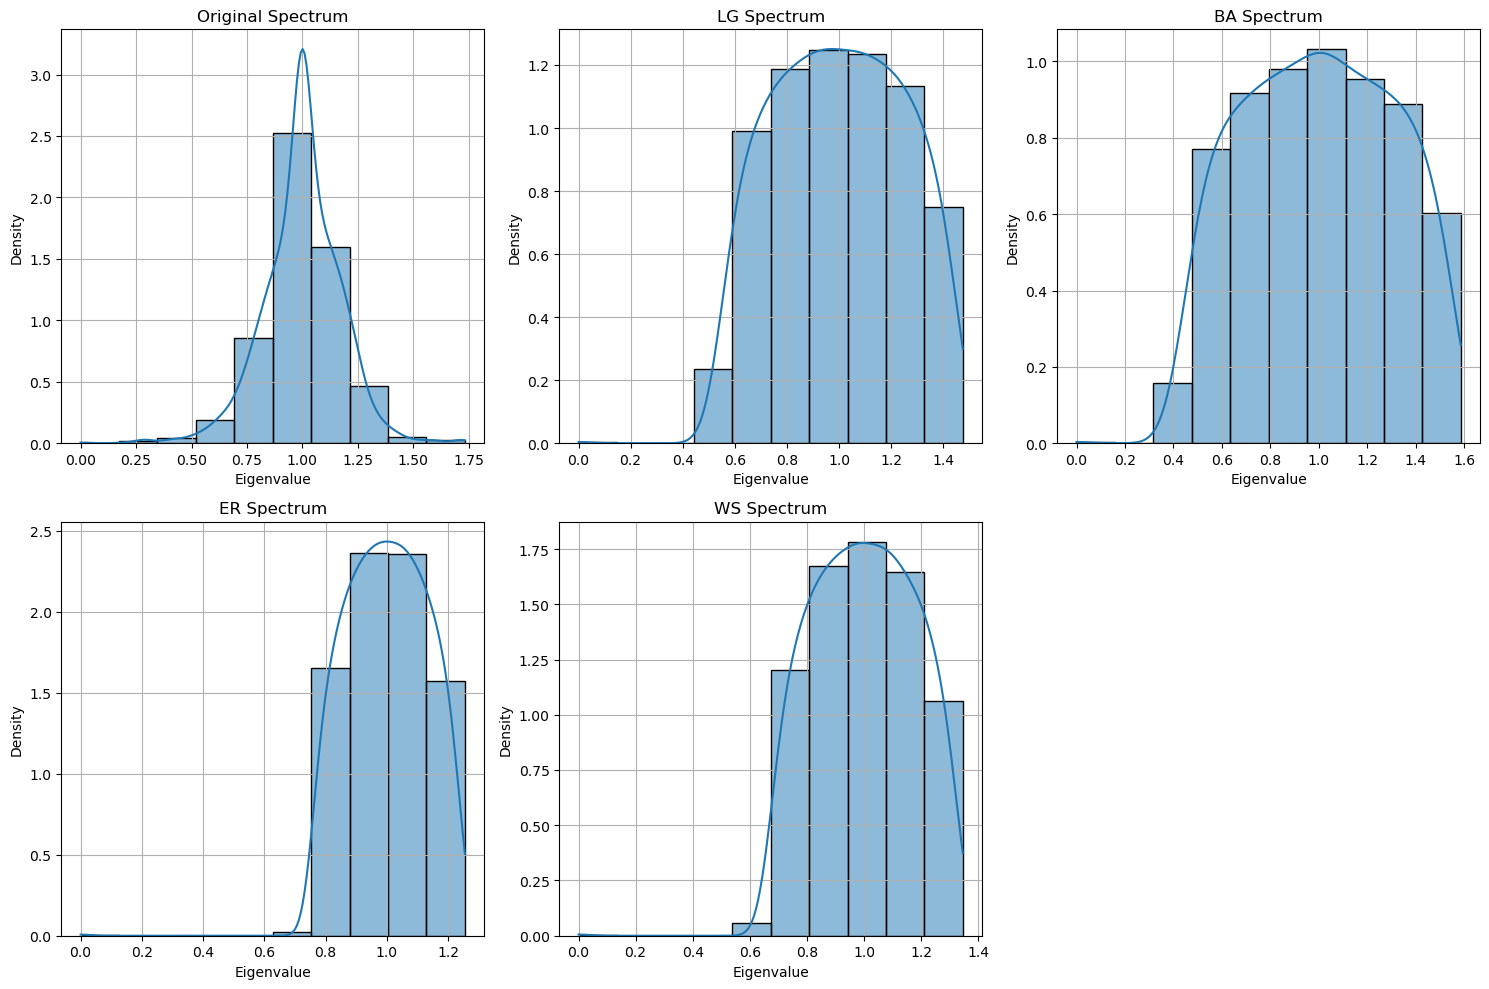

twitch_1_RU_graph.edges


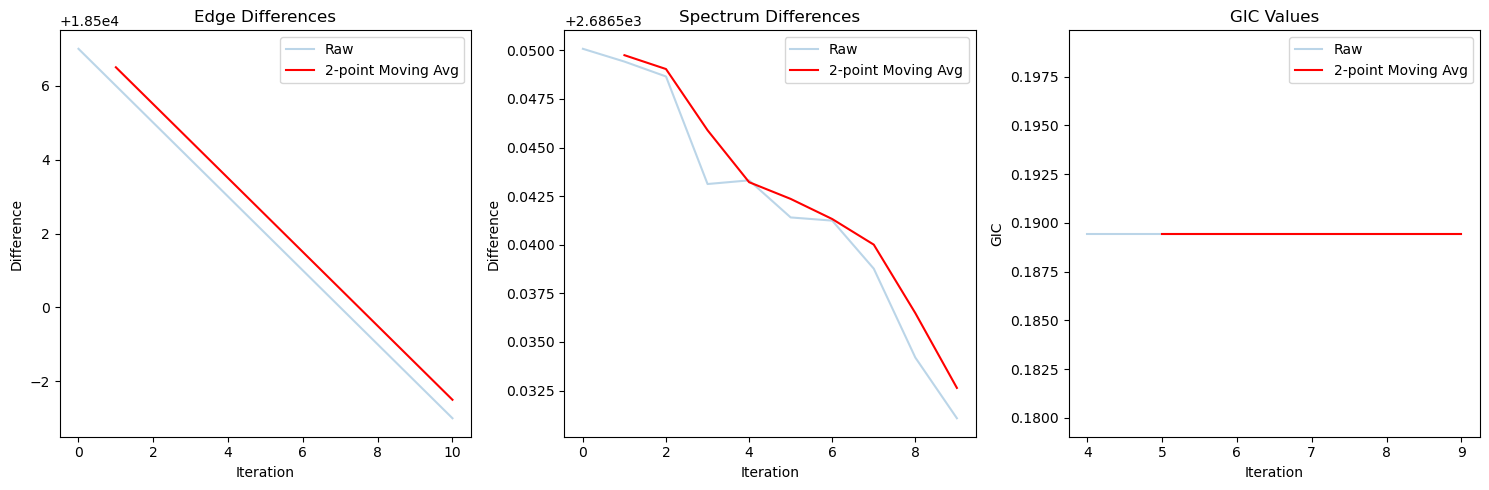

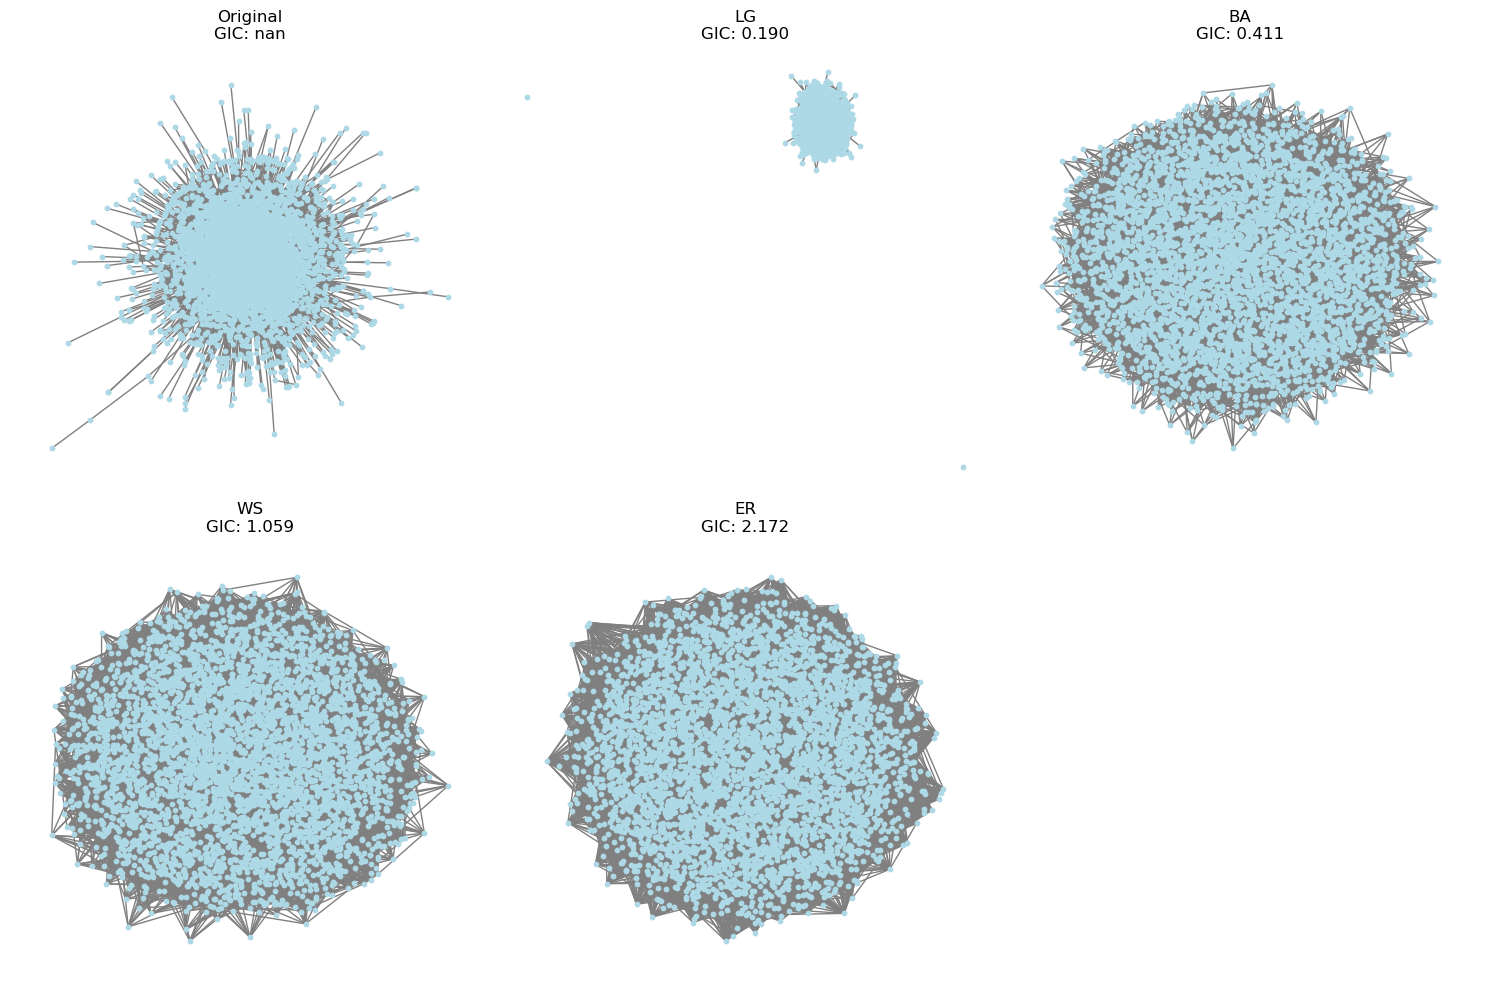

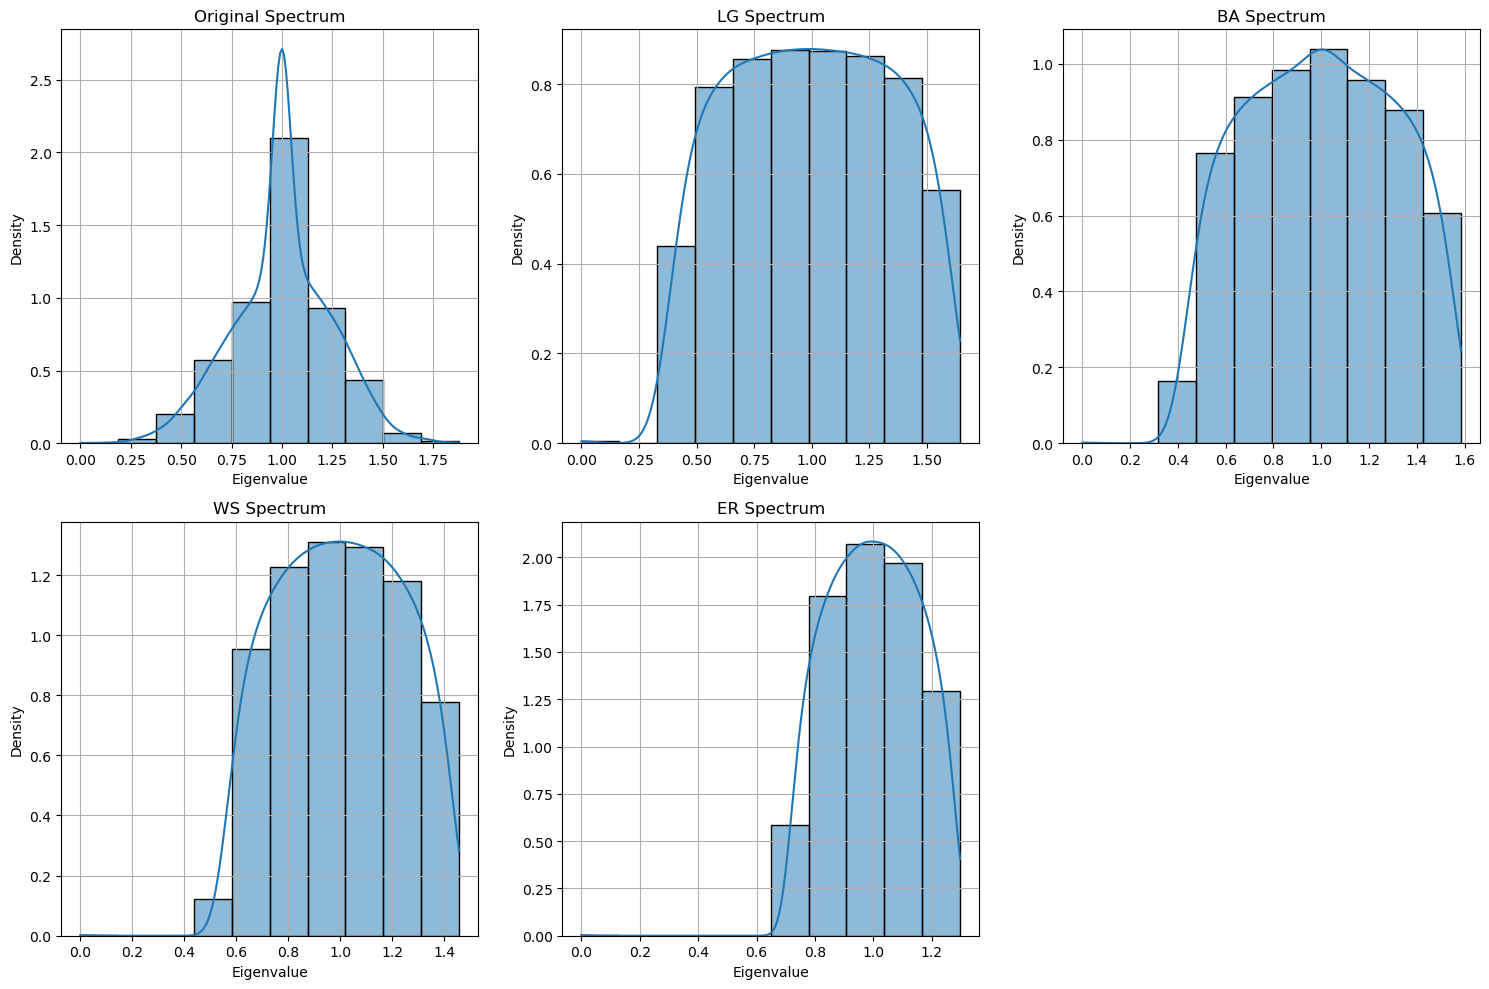

twitch_2_RU_graph.edges


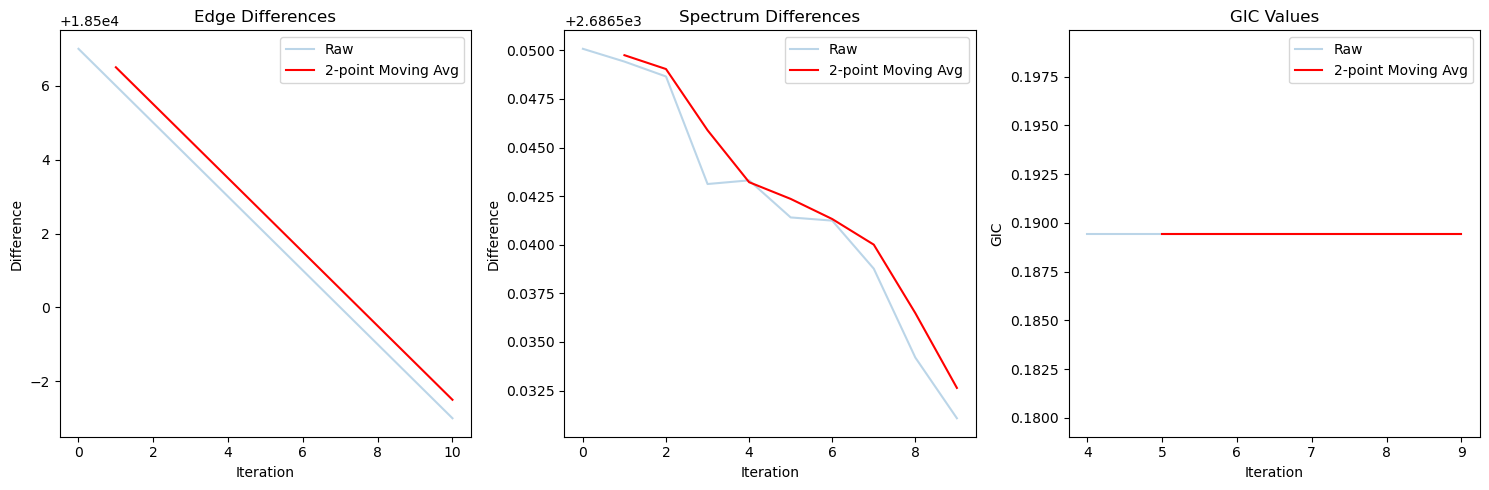

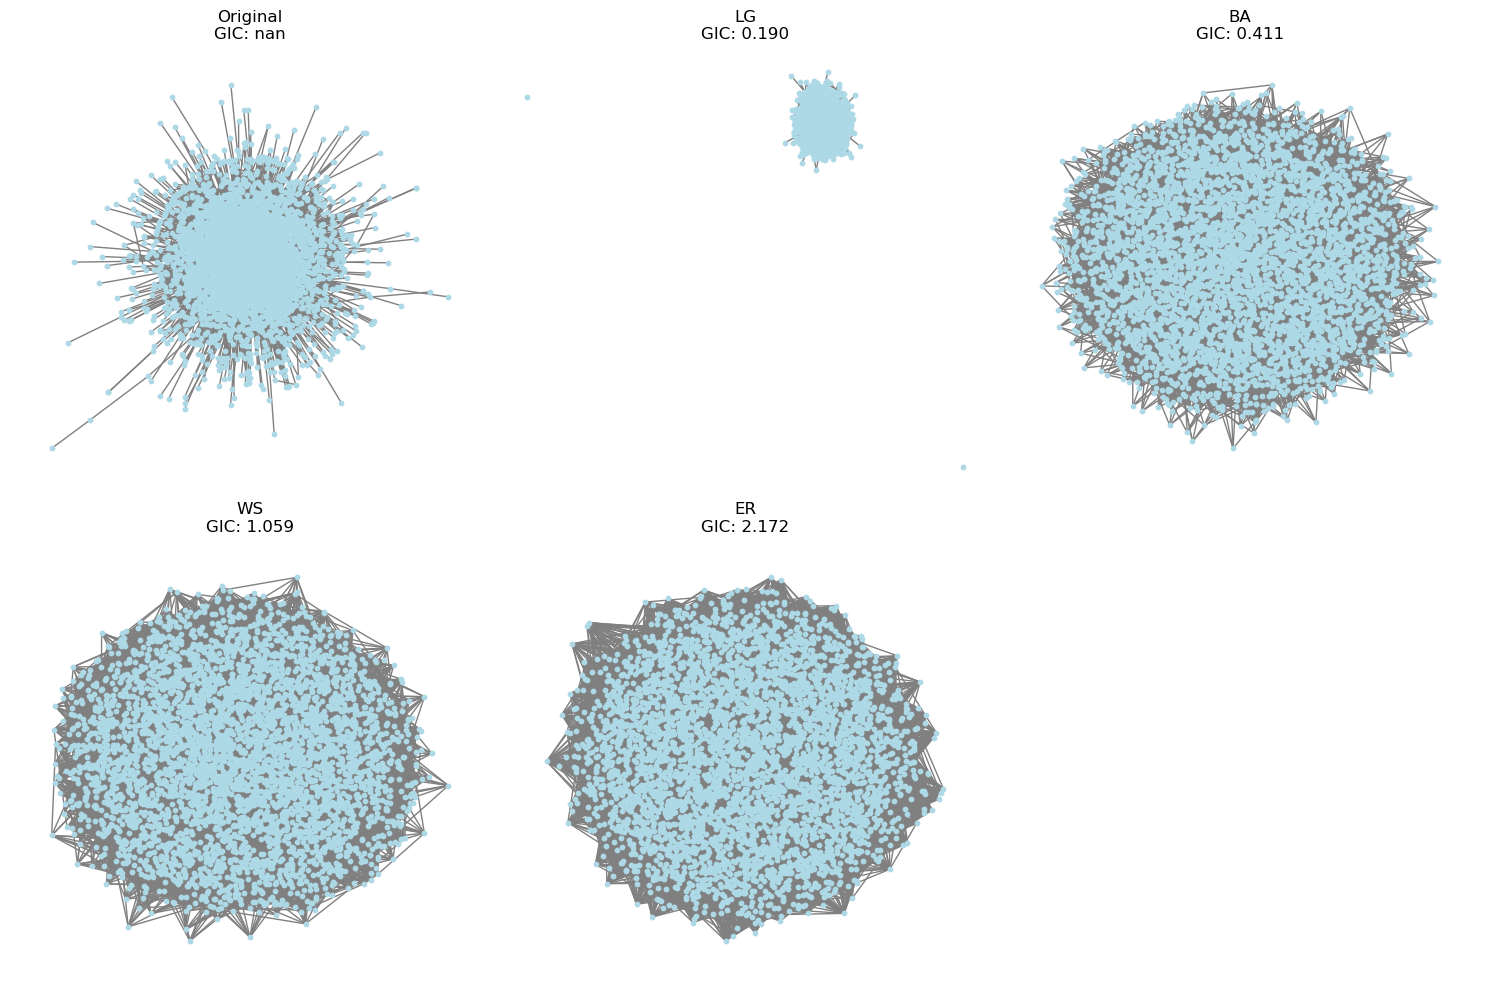

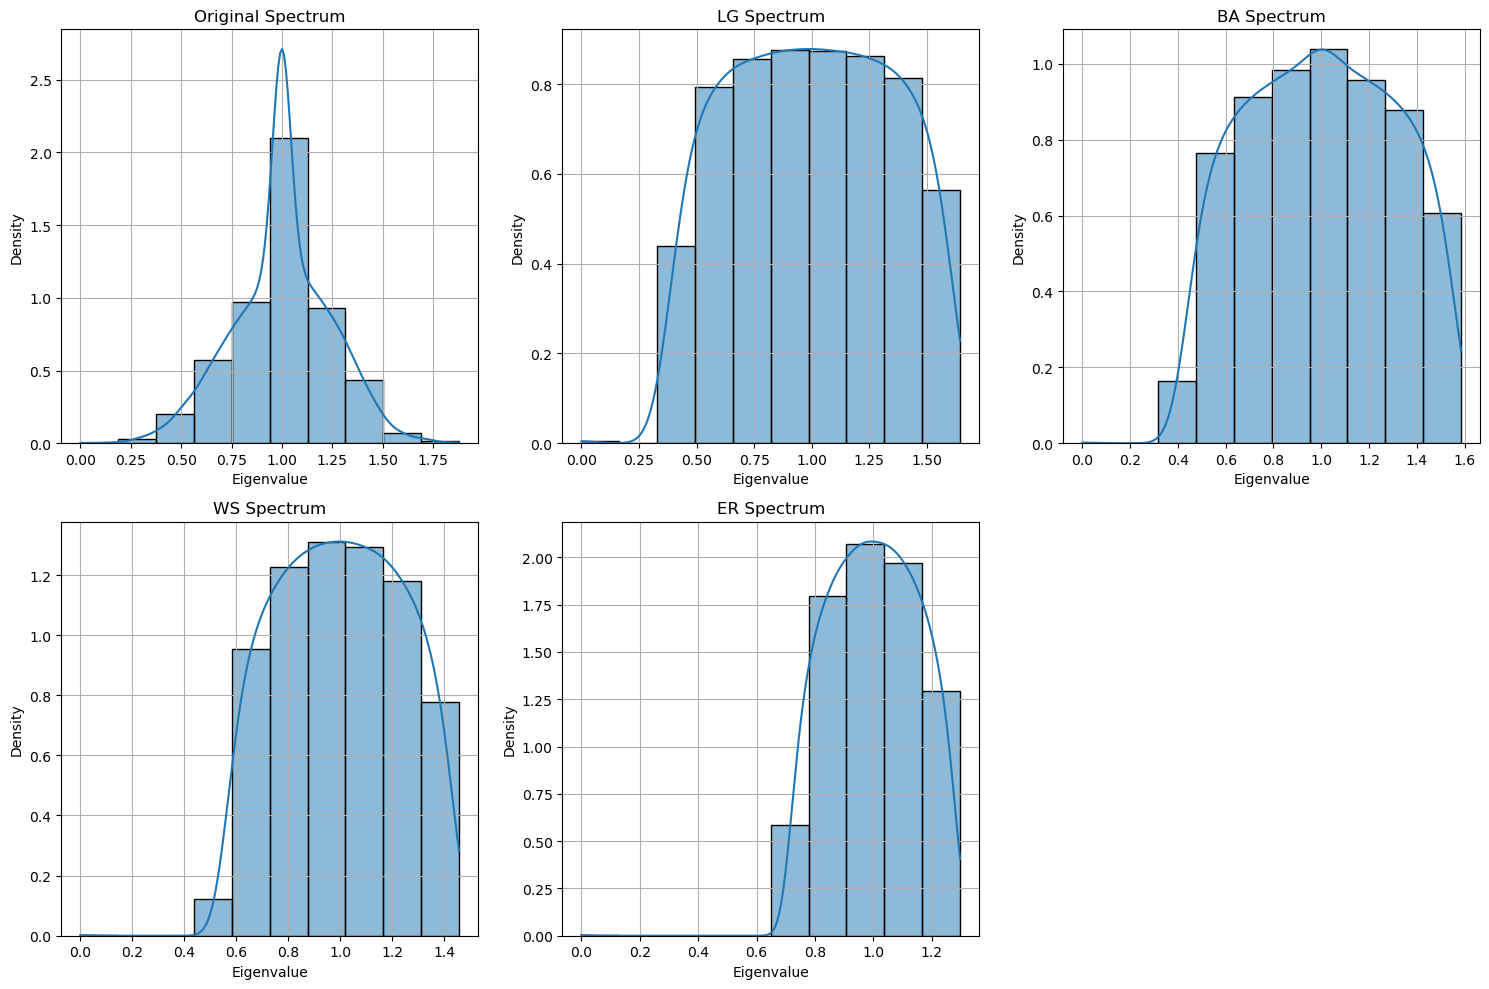

twitch_3_ES_graph.edges


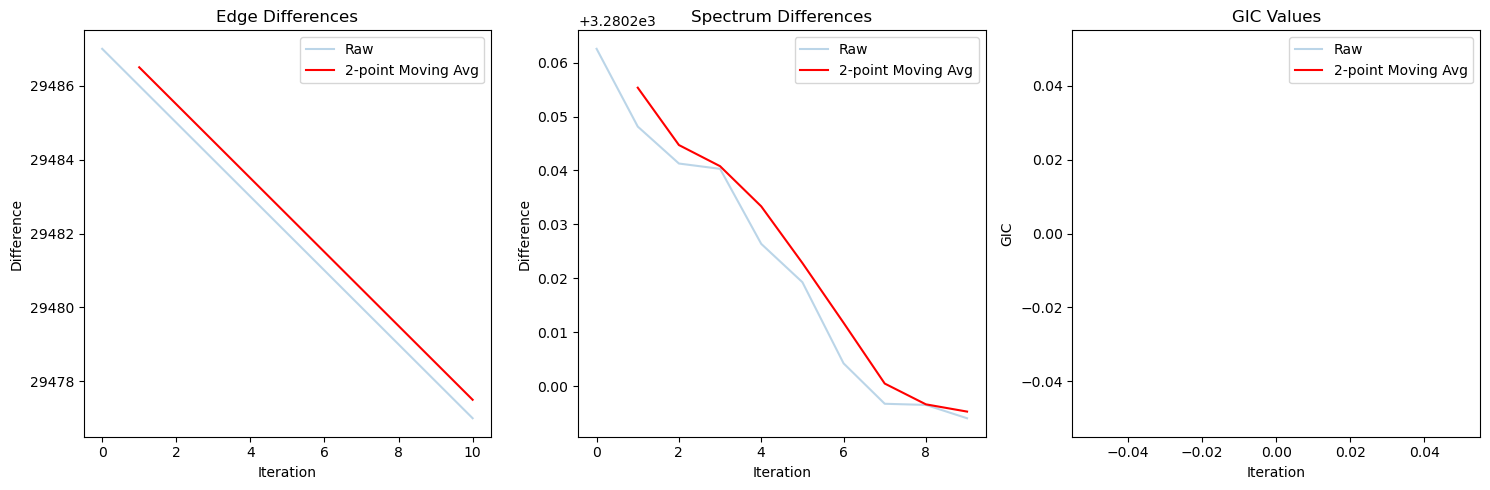

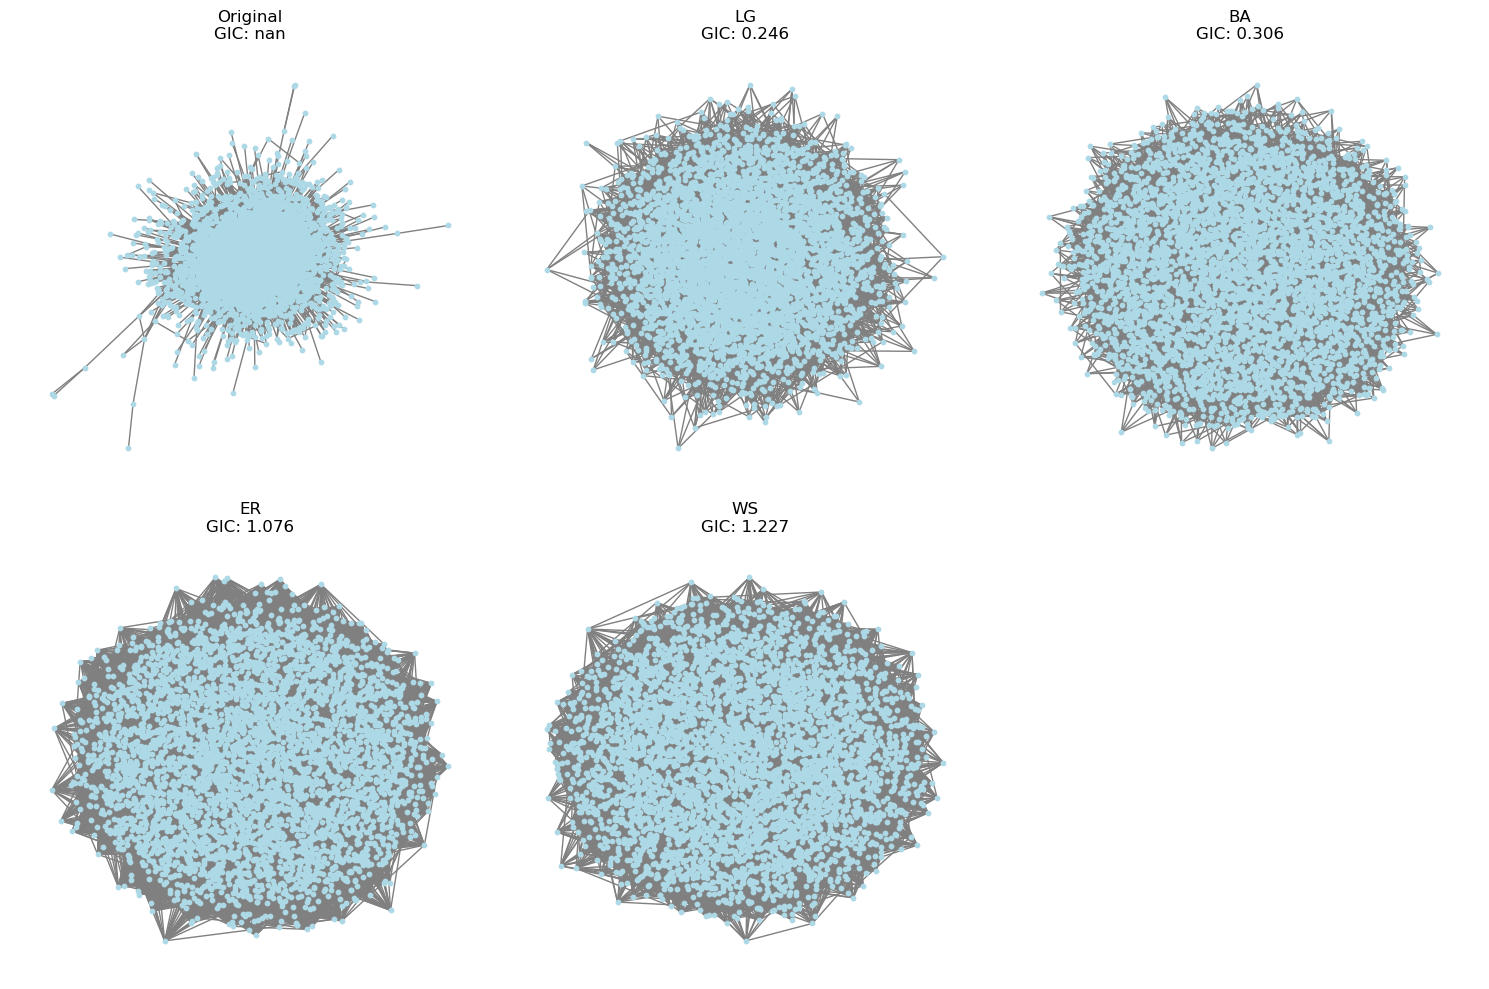

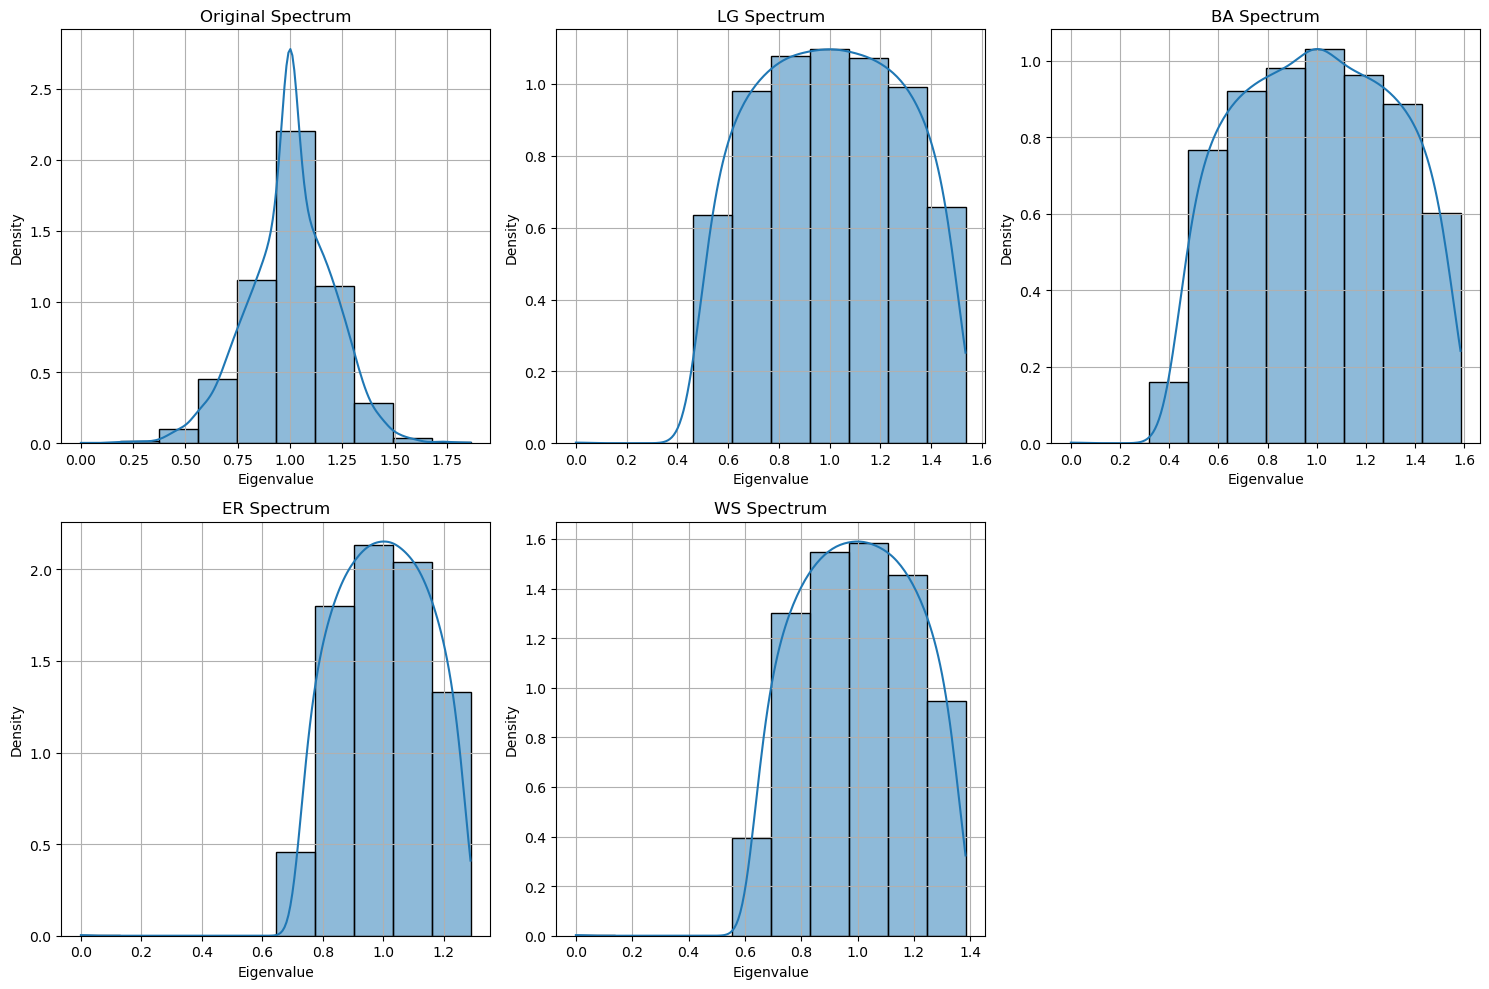

In [113]:

folder = 'imgs_twitch'
os.makedirs(f'{folder}', exist_ok=True)

# Gen all plots
for i in range(len(comparators_all)):
    graph = comparators_all[i]
    graph_name = f'twitch_{i}_{graph.summary_df.graph_filename.iloc[0]}'
    print(graph_name)

    spec_diff = graph.fitted_graphs_data['LG']['metadata']['spectrum_diffs']
    edge_diff = graph.fitted_graphs_data['LG']['metadata']['edge_diffs']
    gic_values = graph.fitted_graphs_data['LG']['metadata']['gic_values']

    # Calculate moving averages with window size of 10
    window = 2
    edge_diff_ma = pd.Series(edge_diff).rolling(window=window).mean()
    spec_diff_ma = pd.Series(spec_diff).rolling(window=window).mean()
    gic_values_ma = pd.Series(gic_values).rolling(window=window).mean()

    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.plot(edge_diff, alpha=0.3, label='Raw')
    plt.plot(edge_diff_ma, 'r-', label=f'{window}-point Moving Avg')
    plt.title('Edge Differences')
    plt.xlabel('Iteration')
    plt.ylabel('Difference')
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(spec_diff, alpha=0.3, label='Raw')
    plt.plot(spec_diff_ma, 'r-', label=f'{window}-point Moving Avg')
    plt.title('Spectrum Differences')
    plt.xlabel('Iteration')
    plt.ylabel('Difference')
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(gic_values, alpha=0.3, label='Raw')
    plt.plot(gic_values_ma, 'r-', label=f'{window}-point Moving Avg')
    plt.title('GIC Values')
    plt.xlabel('Iteration')
    plt.ylabel('GIC')
    plt.legend()

    plt.tight_layout()

    # Save the figure
    plt.savefig(f'{folder}/{graph_name}_iteration.png', bbox_inches='tight', dpi=300)

    plt.show()
    # Get the graph data for each model
    graph_data = graph.fitted_graphs_data

    # Create a figure with subplots for each model
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Plot each graph
    for i, (model, data) in enumerate(graph_data.items()):
        graph2 = data['graph']
        pos = nx.spring_layout(graph2, seed=42)
        
        nx.draw(graph2, pos, ax=axes[i], 
                node_size=10,
                node_color='lightblue',
                edge_color='gray',
                with_labels=False)
        
        # Add title with model name and key metrics
        attrs = data['attributes']
        gic = data['metadata'].get('gic_value', 'N/A')
        title = f"{model}\n"
        # title += f"Nodes: {attrs['nodes']}, Edges: {attrs['edges']}\n"
        # title += f"Density: {attrs['density']:.2f}\n"
        # title += f"Avg Clustering: {attrs['avg_clustering']:.2f}\n"
        title += f"GIC: {gic:.3f}" if isinstance(gic, float) else f"GIC: {gic}"
        axes[i].set_title(title)

    # Remove extra subplot
    axes[-1].remove()

    plt.tight_layout()

    # Save the figure
    plt.savefig(f'{folder}/{graph_name}_graph.png', bbox_inches='tight', dpi=300)

    plt.show()
    # Get the graph data for each model
    graph_data = graph.fitted_graphs_data

    # Create a figure with subplots for each model
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Plot spectrum for each graph
    for i, (model, data) in enumerate(graph_data.items()):
        graph = data['graph']
        
        try:
            # Calculate eigenvalues
            L = nx.normalized_laplacian_matrix(graph)
            eigenvalues = np.linalg.eigvals(L.toarray())
            eigenvalues = np.real(eigenvalues)  # Get real parts
            
            # Plot histogram and KDE with reduced number of bins
            sns.histplot(data=eigenvalues, kde=True, ax=axes[i], stat='density', bins=10)
            axes[i].set_title(f"{model} Spectrum")
            axes[i].set_xlabel("Eigenvalue")
            axes[i].set_ylabel("Density")
            axes[i].grid(True)
        except MemoryError:
            axes[i].text(0.5, 0.5, "Memory Error", ha='center', va='center')
            axes[i].set_title(f"{model} Spectrum (Failed)")

    # Remove extra subplot
    axes[-1].remove()

    plt.tight_layout()

    # Save the figure
    plt.savefig(f'{folder}/{graph_name}_spectrum.png', bbox_inches='tight', dpi=300)

    plt.show()



In [ ]:
123

123